# OpenABM-Covid19 - Recursive Testing

This examples compares contact tracing with and without recursive testing.

In [43]:
import example_utils as utils

n_total = 5e4
frac_lockdown = 0.01
days_lockdown = 60
frac_app_users = 0.75
social_distance_factor = 0.7

Run the model until `frac_lockdown` of the population are infected.

In [44]:
params = utils.get_baseline_parameters()
params.set_param( "n_total", n_total )
params.set_param( "test_insensitive_period", 3 )
params.set_param( "test_sensitivity", 0.8 )
params.set_param( "test_specificity", 0.9 )

app_users_param = [ "app_users_fraction_0_9", "app_users_fraction_10_19",  "app_users_fraction_20_29",  
        "app_users_fraction_30_39",  "app_users_fraction_40_49", "app_users_fraction_50_59",    
        "app_users_fraction_60_69",  "app_users_fraction_70_79", "app_users_fraction_80" ]

for age in range(len(app_users_param)):
    params.set_param( app_users_param[age], params.get_param(app_users_param[age])*frac_app_users)

sim = utils.get_simulation( params )
sim.steps(1)
time_lockdown = 0
while sim.results["total_infected"][ -1] < frac_lockdown * n_total:
    time_lockdown = time_lockdown + 1
    sim.steps(1)

Now turn on a lockdown and continue for `days_lockdown` days.

In [45]:
sim.env.model.update_running_params("lockdown_on", 1)
sim.steps( days_lockdown )

Now turn off the lockdown and turn on digitial contract tracing, with the following options.
1. 80% of people self-quarantine along with their household when they develop symptoms.
2. Tracing happens on a positive test
3. The households members of those traced also quarantine

We then run the simimulation for another 100 days.

In [46]:
# lockdown off
sim.env.model.update_running_params("lockdown_on", 0)

# 80% self-quarantine along with their households
sim.env.model.update_running_params("self_quarantine_fraction", 0.8 )
sim.env.model.update_running_params("quarantine_household_on_symptoms", 1 )
  
# turn on the app and quarantine those people who have been traced along with their households
sim.env.model.update_running_params("app_turned_on", 1 )
sim.env.model.update_running_params("quarantine_on_traced", 1 )
sim.env.model.update_running_params("trace_on_positive", 1 )
sim.env.model.update_running_params("trace_on_symptoms", 1 )
sim.env.model.update_running_params("test_on_symptoms", 1 )
sim.env.model.update_running_params("test_on_traced", 0 )
sim.env.model.update_running_params("test_result_wait", 2 )
sim.env.model.update_running_params("test_order_wait", 1 )

sim.env.model.update_running_params("quarantine_household_on_traced_positive", 1 )

# apply social distancing measures
sim.env.model.update_running_params("relative_transmission_occupation", social_distance_factor )
sim.env.model.update_running_params("relative_transmission_random", social_distance_factor )

# step forwrard another 100 days
sim.steps( 100 )

Finally plot the result.

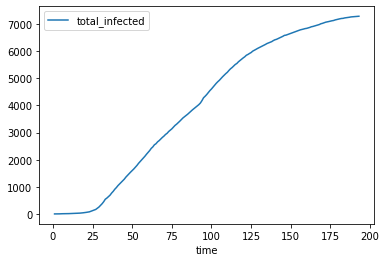

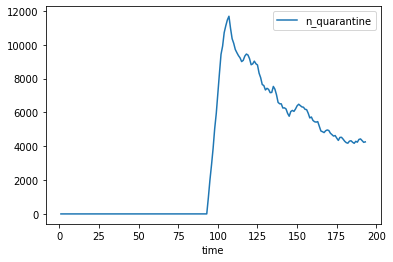

In [47]:
import pandas as pd
timeseries = pd.DataFrame( sim.results )
timeseries.plot( x = "time", y = "total_infected" )
timeseries.plot( x = "time", y = "n_quarantine" )

In [48]:
del( sim )